# Analysis and Summarization of Legal Case Reports

# Introduction

This notebook contains the analysis and summarization of legal cases reports from the Federal Court of Australia (FCA), from 2006 to 2009. The dataset used in the notebook contains citations and full text decision of legal cases.

The objective of this project is to generate a citation-based clustered summary for the cases in the dataset. The generated summaries gives a general idea of the cases in each cluster. This is based on the assumption that similar cases will have similar citations quoted, hence, the need for clustering cases based on similar citations

The following steps have been taken to achieve our overall objectives:

1. Text preprocessing: Importing the cases (as XML files), extracting the catchphrases, sentences, citations, and pre-processing them

2. Clustering cases based on citations

3. Summarize cases in each Cluster

4. Evalution of Summaries

## Import Packages

In [1]:
import re
import os
import nltk
import pickle
import justext
import nltk.data
import pandas as pd 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from infomap import Infomap

stop_words = stopwords.words('english')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
treebank_tokenizer = TreebankWordTokenizer()

# Section 1

## Text Preprocessing
- Set working directory
- Create a new directory that stores the cleaned catchphrases from full text legal reports- 'catch_directory'
- Create a new directory that stores the cleaned sentences from full text legal reports - 'sent_directory'
- Read and parse through case files using BeautifulSoup
- Extract and clean the Name, Catchphrases and Sentences of each case 
- In gold_catch{}, key - 'Catchphrases', value - the extracted catchphrases
- In gold_sent{}, key - 'Sentences', value - the extracted sentences
- Store each gold_sent_ and gold_catch in folder 'data' as pickle file

In [2]:
# set directory to case reports
base_dir = 'data/fulltext'

# Make directory to store extracted catchphrases
catch_directory = os.path.dirname('data/cleanedcatch/')
if not os.path.exists(catch_directory):
    os.makedirs(catch_directory)

# Make directory to store extracted sentences
sent_directory = os.path.dirname('data/cleanedsent/')
if not os.path.exists(sent_directory):
    os.makedirs(sent_directory)
    

# read in case files
for num, filename in enumerate(os.scandir(base_dir)):
    with open(filename, 'rb') as case_file:
            # parse case file into beautiful soup
            soup = BeautifulSoup(case_file, 'xml')
            
            # create 2 dictionaries to store the case names as key 
            # and list of sentences and catchphrases as values
            gold_sent = {}
            gold_catch = {}
            
            # obtain all case names in the case files
            names = soup.find_all('name')

            # obtain all catchphrases in the case file
            catchphrases = soup.find_all('catchphrase')
            
            # obtain all sentences in the case file
            sentences = soup.find_all('sentence')
            
            # clean and store the extracted names
            for name in names:
                na = name.text
                na = re.sub(r'\([^)]*\)|(\[[^)]*\])|(FCA)|(\d+)', '', na)
                na = na.strip()    
                
            # clean and store the extracted catchphrases 
            gold_catchphrases = []
            for catchphrase in catchphrases:
                text = catchphrase.text
                text = re.sub(r'.*>','',text)
                gold_catchphrases.append(text)
                
            # clean and store the extracted sentences                
            gold_sentences = []
            for sentence in sentences:
                text = sentence.text
                text = text.strip()
                text = text.strip('.')
                text = text.lstrip('0123456789.- ')
                text = re.sub(r'(( [\d])$)|(.*>)|(\n)','',text)
                text = text.strip()
                gold_sentences.append(text)
                
                
            # remove any missing sentences
            gold_sentences = [x for x in gold_sentences if x]

            # store the name as key and the sentences as value
            gold_sent[na] = gold_sentences
            
            # store the name as key and the catchphrases as value
            gold_catch[na] = gold_catchphrases                             
            
            num += 1
            num = str(num)
            
            # save catchphrases as pickle
            pickle_out = open(os.path.join(catch_directory, num),"wb")
            pickle.dump(gold_catch, pickle_out)
            pickle_out.close()
            
            # save sentences as pickle
            pickle_out = open(os.path.join(sent_directory, num),"wb")
            pickle.dump(gold_sent, pickle_out)
            pickle_out.close()

In [3]:
# Checking sample sent_text files and catch_text files
# c = pd.read_pickle("data/cleanedsent/1")
# print(c)

## Citation Extraction and Cleaning

In [4]:
# set directory to citations class
base_dir = 'data/citations_class'

# Make directory to store extracted citations
citation_directory = os.path.dirname('data/citation_text/')
if not os.path.exists(citation_directory):
    os.makedirs(citation_directory)
    
# read in citation files
for num, filename in enumerate(os.scandir(base_dir)):
    with open(filename, 'rb') as case_file:
            # parse citation file into beautiful soup
            soup = BeautifulSoup(case_file, 'xml')
            
            # obtain all citations in the citations file
            citations = soup.find_all('name')
            
            # obtain all cited cases in the citations file
            cited = soup.find_all('tocase')
            
            # obtain all text in identified citations and store them together
            gold_citations = []
            for citation in citations:
                text = citation.text
                # Cleaning citation part by removing all the years and courts mentioned
                text = re.sub(r'\([^)]*\)|(\[[^)]*\])|(FCA)|(\d+)', '', text)
                text = text.strip()
                gold_citations.append(text)
            
            # obtain all text in identified cited citations and store them together
            gold_cited = []
            for citation in cited:
                text = citation.text
                # Cleaning citation part by removing all the years and courts mentioned
                text = re.sub(r'\([^)]*\)|(\[[^)]*\])|(\d+)|(FCA)|(;)', '', text)
                text = re.sub(r'[ ]{2,}',' ',text)
                text = text.strip()
                text = re.sub(r'[A-Z]{2,}$','',text)
                text = text.strip()
                text = re.sub(r'[A-Z]{2,}$','',text)
                text = text.strip()
                text = re.sub(r'[A-Z]{2,}$','',text)
                text = text.strip()
                gold_cited.append(text)
            
            num += 1
            num = str(num)
            
            # add them together
            gold_citations = gold_citations + gold_cited
            
            # save citations as pickle
            pickle_out = open(os.path.join(citation_directory, num),"wb")
            pickle.dump(gold_citations, pickle_out)
            pickle_out.close()

In [5]:
# Checking sample citation_text file
# c = pd.read_pickle("data/citation_text/83")
# print(c)

# Section 2

## Clustering cases based on Citations

In [6]:
# create dictionary to store citations
citation_dict = {}

# read in all citation files and store case name as keys and cited cases as values in citation_dict
for i in range(1,2755):
    citation_text = pd.read_pickle("data/citation_text/"+str(i))
    if citation_text[0] not in citation_dict.keys():
        citation_dict[citation_text[0]] = citation_text[1:]
    else:
        citation_dict[citation_text[0]].extend(citation_text[1:])

# dictionary to assign numbers to cases i.e numbers as keys and case names as values
num_dict = {}
# dictionary to assign cases to numbers i.e case names as keys and numbers as values
dict_num = {}
dict_keys = list(citation_dict.keys())
dict_values = list(citation_dict.values())
dict_values = [item for sublist in dict_values for item in sublist]
citation_list = list(set(dict_keys + dict_values))
for i in range(len(citation_list)):
    num_dict[i] = citation_list[i]
    dict_num[citation_list[i]] = i


# dictionary with case numbers instead of case names (for infomap)
citation_dict_num = {}
for i in range(len(num_dict.keys())):
    if num_dict[i] in dict_keys:
        citation_dict_num[i] = []
        for j in range(len(citation_dict[num_dict[i]])):
            if i in citation_dict_num.keys():
                citation_dict_num[i].append(dict_num[citation_dict[num_dict[i]][j]])
            else:
                citation_dict_num[i] = dict_num[citation_dict[num_dict[i]][j]]

In [7]:
im = Infomap()

# Creating nodes and links between nodes for infomap
for i in citation_dict_num.keys():
    for j in range(len(citation_dict_num[i])):
        im.add_link(i,citation_dict_num[i][j])

        
# Run the Infomap search algorithm to find optimal modules
im.run()
        
modules_dict = im.get_modules()

In [8]:
# dictionary with clusters as keys and case numbers as values
cluster_dict = {}
for node in im.tree:
    if node.is_leaf:
        if num_dict[node.node_id] in dict_keys:
            if node.module_id in cluster_dict.keys():
                cluster_dict[node.module_id].append(node.node_id)
            else:
                cluster_dict[node.module_id] = [node.node_id]


# dictionary with clusters as keys and case numbers as values (clusters with >=10 cases)
top_clusters_dict = {}
for key,value in cluster_dict.items():
    #print(key, len(value))
    if len(value) >= 10:
        top_clusters_dict[key] = value


# dictionary with keys as cluster number and values as names of cases
top_clusters_dict_name = {}
for key in top_clusters_dict.keys():
    top_clusters_dict_name[key] = []
    for value in top_clusters_dict[key]:
        if key in top_clusters_dict_name.keys():
            top_clusters_dict_name[key].append(num_dict[value])
        else:
            top_clusters_dict_name[key] = num_dict[value]
            
                                                   
# dictionary with clusters as keys and number of cases in that cluster as values
top_cluster_num_cases = {}
for key,value in cluster_dict.items():
    if len(value) >= 10:
        top_cluster_num_cases[key] = len(value)
print(top_cluster_num_cases)

{1: 618, 2: 85, 3: 125, 4: 83, 5: 53, 6: 111, 7: 65, 8: 42, 9: 67, 10: 50, 11: 43, 12: 31, 13: 39, 14: 38, 15: 37, 16: 34, 17: 34, 18: 39, 19: 44, 20: 43, 21: 22, 22: 40, 23: 21, 24: 18, 25: 20, 26: 13, 27: 19, 28: 19, 29: 23, 30: 17, 31: 12, 33: 12, 34: 13, 35: 15, 36: 11, 37: 19, 38: 11, 40: 10, 46: 10}


In [9]:
# total number of cases in all 38 clusters for summarization
final_num_cases = sum(top_cluster_num_cases.values())
final_num_cases

2006

In [10]:
# Saving the dictionary as pickle file
cluster_directory = os.path.dirname('data/clusterdata/')
if not os.path.exists(cluster_directory):
    os.makedirs(cluster_directory)

pickle_out = open(os.path.join(cluster_directory, 'clusters'),"wb")
pickle.dump(top_clusters_dict_name, pickle_out)
pickle_out.close()

In [11]:
# Checking clusters pickle file
# c = pd.read_pickle("data/clusterdata/clusters")
# print(c)

## Merging cases together in the same cluster

In [12]:
from collections import defaultdict

# create dictionaries to store all reference summaries and generated summaries per cluster
ref_summary = defaultdict(list)
to_summarize = defaultdict(list)

# import clustered cases
case_clusters = pd.read_pickle("data/clusterdata/clusters")

# read in all cleaned sentences(cases) and catchphrases(summaries), cluster actual cases and catchphrases
# in the same cluster together
for i in range(1, 3890):
    reference = pd.read_pickle("data/cleanedcatch/"+str(i))
    case = pd.read_pickle("data/cleanedsent/"+str(i))
    
    for cluster in case_clusters.keys():
        sent = list(case.keys())
        # check if case is in cluster
        if (all(x in case_clusters[cluster] for x in sent)):
                       
            # add sentence to cases in the cluster
            to_summarize[cluster].extend(case.values())
            
            # add catchphrases to reference summary in the cluster
            ref_summary[cluster].extend(reference.values())

# Section 3

## Text Summarization for each cluster

In [14]:
# import packages to use for summaries
from gensim.summarization.summarizer import summarize
from gensim.summarization.summarizer import summarize_corpus

# create dictionaries to cluster summaries 
cluster_summaries = {}

for cluster, cases in to_summarize.items():
    # obtain summary for each cluster
    cluster_summaries[cluster] = summarize_corpus(cases, ratio=0.1)

In [30]:
# checking the summary generated in a cluster
# cluster_summaries[39]
# cluster_summaries[40]

# Section 4

## Summarization Evaluation

We will implement the Recall-Oriented Understudy for Gisting Evaluation (ROUGE-N) to evaluate how well our summary is generated. 

The recall in the context of ROUGE-N measures how much of the reference summary is captured by the generated summary

                Recall = Number of overlapping words / Total number of words in reference summary
                
The precision in the context of ROUGE-N measures how much of the generated summary is relevant
    
                Precision = Number of overlapping words / Total number of words in generated summary

We will be carrying out evaluation at the single word (token) and two-words (bigram) level which are respective ROUGE-1 and ROUGE-2

In [16]:
# ROUGE-1 (for tokens)
overlapping_words_count_1 = {} 
all_summary_count_1 = {}
all_reference_count_1 = {} 
tokenized_summary = {} 
tokenized_reference = {}

# ROUGE-2 (for bigrams)
overlapping_words_count_2 = {} 
all_summary_count_2 = {}  
all_reference_count_2 = {} 
bigrams_reference = {}
bigrams_summary = {}

# tokenize all words in each cluster summary
for cluster, summary in cluster_summaries.items():
    summary = ' '.join(map(str, summary))
    tokens = treebank_tokenizer.tokenize(summary)
    tokens = [word for word in tokens if word not in stop_words]
    tokenized_summary[cluster] = tokens
    bigrams_summary[cluster] = list(nltk.bigrams(tokens))

# tokenize all words in each cluster reference
for cluster, reference in ref_summary.items():
    reference = ' '.join(map(str, reference))
    tokens = treebank_tokenizer.tokenize(reference)
    tokens = [word for word in tokens if word not in stop_words]
    bigrams_reference[cluster] = list(nltk.bigrams(tokens))
    tokenized_reference[cluster] = tokens

In [17]:
# count overlapping words in each cluster
for i, token_summary in tokenized_summary.items():
    all_summary_count_1[i] = len(token_summary)
    
    for j, token_ref in tokenized_reference.items():
        all_reference_count_1[j] = len(token_ref)
        count = 0
        
        if i == j:
            for word in token_ref:
                if word in token_summary:
                    count += 1
            overlapping_words_count_1[j] = count

In [18]:
# count overlapping bigrams in each cluster
for i, bigram_summary in bigrams_summary.items():
    all_summary_count_2[i] = len(bigram_summary)
    
    for j, bigram_ref in bigrams_reference.items():
        all_reference_count_2[j] = len(bigram_ref)
        count = 0
        
        if i == j:
            for bigram in bigram_ref:
                if bigram in bigram_summary:
                    count += 1
            overlapping_words_count_2[j] = count

In [19]:
def calc_recall(overlapping_word_count, reference_word_count):
    rouge_1_recall = {}
    for i, ref_count in reference_word_count.items():
        for j, score in overlapping_word_count.items():
            if i == j:
                rouge_1_recall[j] = overlapping_word_count[j]/reference_word_count[i]
    return rouge_1_recall

def calc_precision(overlapping_word_count, summary_word_count):
    rouge_1_precision = {}
    for i, sum_count in summary_word_count.items():
        for j, score in overlapping_word_count.items():
            if i == j:
                if not summary_word_count[i]:
                    rouge_1_precision[j] = 0
                else:
                    rouge_1_precision[j] = overlapping_word_count[j]/summary_word_count[i]
    return rouge_1_precision

In [20]:
# ROUGE-1 Recall and Precision
rouge_1_recall = calc_recall(overlapping_words_count_1, all_reference_count_1)
rouge_1_precision = calc_precision(overlapping_words_count_1, all_summary_count_1)

# ROUGE-2 Recall and Precision
rouge_2_recall = calc_recall(overlapping_words_count_2, all_reference_count_2)
rouge_2_precision = calc_precision(overlapping_words_count_2, all_summary_count_2)

In [21]:
# create data frame for ROUGE-1 scores
df_rogue_1_recall = pd.DataFrame.from_dict(rouge_1_recall, orient='index',
                       columns=['recall']).reset_index()
df_rogue_1_recall = df_rogue_1_recall.rename(columns={"index": "Cluster", "recall": "Recall"}).sort_values(by=['Cluster'])


df_rogue_1_precision = pd.DataFrame.from_dict(rouge_1_precision, orient='index',
                       columns=['Precision']).reset_index()
df_rogue_1_precision = df_rogue_1_precision.rename(columns={"index": "Cluster"}).sort_values(by=['Cluster'])

# merge both recall and precision in one dataframe
df_rogue_1_recall_and_precision = pd.merge(df_rogue_1_recall, df_rogue_1_precision, on='Cluster', how='outer')

# set the cluster column as index
df_rogue_1_recall_and_precision = df_rogue_1_recall_and_precision.set_index('Cluster')

In [31]:
df_rogue_1_recall_and_precision

,Recall,Precision
Cluster,,
1,0.881316,0.115485
2,0.859986,0.016544
3,0.844233,0.103896
4,0.858847,0.014901
5,0.815502,0.079886
6,0.783186,0.137614
7,0.827266,0.037296
8,0.787498,0.076074
9,0.875647,0.030312


In [22]:
# create data frame for ROUGE-2 scores
df_rogue_2_recall = pd.DataFrame.from_dict(rouge_2_recall, orient='index',
                       columns=['recall']).reset_index()
df_rogue_2_recall = df_rogue_2_recall.rename(columns={"index": "Cluster", "recall": "Recall"}).sort_values(by=['Cluster'])


df_rogue_2_precision = pd.DataFrame.from_dict(rouge_2_precision, orient='index',
                       columns=['Precision']).reset_index()
df_rogue_2_precision = df_rogue_2_precision.rename(columns={"index": "Cluster"}).sort_values(by=['Cluster'])

# merge both recall and precision in one dataframe
df_rogue_2_recall_and_precision = pd.merge(df_rogue_2_recall, df_rogue_2_precision, on='Cluster', how='outer')

# set the cluster column as index
df_rogue_2_recall_and_precision = df_rogue_2_recall_and_precision.set_index('Cluster')

Text(0.5, 1.0, 'Line Plot of ROUGE-1 Precision/Recall and Case Clusters')

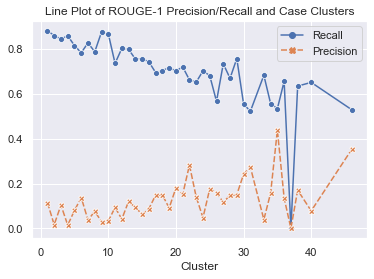

In [23]:
rouge1_plot = sns.lineplot(data=df_rogue_1_recall_and_precision, markers=True)
plt.title("Line Plot of ROUGE-1 Precision/Recall and Case Clusters")

Text(0.5, 1.0, 'Line Plot of ROUGE-2 Precision/Recall and Case Clusters')

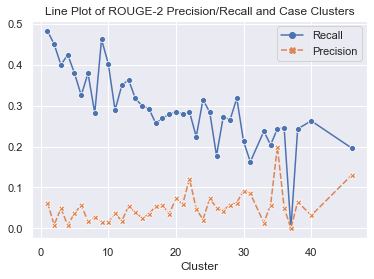

In [24]:
rouge2_plot = sns.lineplot(data=df_rogue_2_recall_and_precision, markers=True)
plt.title("Line Plot of ROUGE-2 Precision/Recall and Case Clusters")

# Summary

3890 legal cases reports obtained from the Federal Court of Austrialia between 2006 to 2009 have been utilized in this project. The cases were preprocessed to extract the catchphrases (to be used as reference summary for evaluation) and actual case decisions. Also, citations and cases cited were extracted. Other irrelevant characters and figures were removed.

Furthermore, the cases were clustered based on similar citations in the different cases reports. 281 clusters were generated with cluster 1 having 618 cases while several clusters had just a case. Clusters with more than 10 cases per cluster were selected for case summarization. 39 clusters representing 51.56% (2006) of all cases were feed to the textrank algorithm for summarization. This is an extractive summarization method. Summaries were generated for all 39 cluster with the exception of cluster 37.

The metric chosen for evaluating the summaries generated was the Recall-Oriented Understudy for Gisting Evaluation (ROUGE-N). The recall and precision for monogram (ROUGE-1) and bigram (ROUGE-2) were plot for all clusters. The same recall and precision trend is observed when the summaries are evaluated as monogram and bigram. For ROUGE-1, the maximum recall score was recorded as 0.8813 for cluster 1, with a close score for cluster 9 at 0.8756. The minimum recall score was 0 at cluster 37, since no summary was generated, cluster 31 comes close at 0.5217. Generally, the summaries had low precision scores with a maximum at cluster 46 (0.3525) and a minimum at cluster 4 (0.0149).

A great deal of work has been done to generate the summaries for each cluster. The summaries generated gives a good representation of cases that are similar based on citations, judging by an overall recall score greater than 0.5. These summaries can be used in getting an overall understanding of the cases within the period 2006 - 2009.